<a href="https://colab.research.google.com/github/giyuntf2/1day1commit/blob/main/%EB%85%BC%EB%AC%B8%EA%B5%AC%ED%98%84/AlexNet/ALEXNET.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# AlexNet

In [1]:
import os 
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch 
import torchvision 
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F 
from PIL import Image
from torchvision import transforms, datasets
from torch.utils.data import Dataset, DataLoader

In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

In [3]:
epochs = 30
batch_size = 512

class_names = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat',
               'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']

In [4]:
transform = transforms.Compose([
    transforms.Resize(227),
    transforms.ToTensor()
])

mnist_train = datasets.FashionMNIST(root='data',
                            train=True,
                            transform=transform,
                            download=True)

mnist_test = datasets.FashionMNIST(root='data',
                            train=False,
                            transform=transform,
                            download=True)

  0%|          | 0/26421880 [00:00<?, ?it/s]

Extracting data/FashionMNIST/raw/train-images-idx3-ubyte.gz to data/FashionMNIST/raw



  0%|          | 0/29515 [00:00<?, ?it/s]

Extracting data/FashionMNIST/raw/train-labels-idx1-ubyte.gz to data/FashionMNIST/raw



  0%|          | 0/4422102 [00:00<?, ?it/s]

Extracting data/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to data/FashionMNIST/raw



  0%|          | 0/5148 [00:00<?, ?it/s]

Extracting data/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to data/FashionMNIST/raw



In [5]:
training_loader = DataLoader(mnist_train, batch_size=64, shuffle=True)
test_loader = DataLoader(mnist_test, batch_size=64, shuffle=True)

Coat


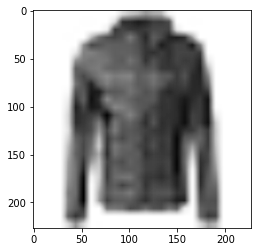

In [6]:
# helper function to show an image
def matplotlib_imshow(img):
    img = img.mean(dim=0)
    img = img / 2 + 0.5
    npimg = img.numpy()
    plt.imshow(npimg, cmap="Greys")
    
dataiter = iter(training_loader)
images, labels = dataiter.next() 

# create grid of images
img_grid = torchvision.utils.make_grid(images[0])

# show images & labels
matplotlib_imshow(img_grid)
print(class_names[labels[0]])

# AlexNet 1

In [107]:
class AlexNet(nn.Module):
    def __init__(self):
        super().__init__()
        
        self.conv1 = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=96, kernel_size=11, stride=4, padding=0),
            #MNIST를 사용하므로, gray_scale.
            #input_size = 1x227x227
            #(N,C,H,W) or (C,H,W)
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=3, stride=2)
        )

        self.conv2 = nn.Sequential(
            nn.Conv2d(in_channels=96, out_channels=256, kernel_size=5, stride=1, padding=2),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=3, stride=2)
        )

        self.conv3 = nn.Sequential(
            nn.Conv2d(in_channels=256, out_channels=384, kernel_size=3, stride=1, padding=1),
            nn.ReLU()
        )

        self.conv4 = nn.Sequential(
            nn.Conv2d(in_channels=384, out_channels=384, kernel_size=3, stride=1, padding=1),
            nn.ReLU()
        )

        self.conv5 = nn.Sequential(
            nn.Conv2d(in_channels=384, out_channels=256, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=3, stride=2)
        )

        self.fc1 = nn.Linear(256 * 6 * 6, 4096)
        self.fc2 = nn.Linear(4096, 4096)
        self.fc3 = nn.Linear(4096, 10)

    def forward(self, inputs):
        out = self.conv1(inputs)
        out = self.conv2(out)
        out = self.conv3(out)
        out = self.conv4(out)
        out = self.conv5(out)
        out = out.view(out.size(0), -1)

        out = F.relu(self.fc1(out))
        out = F.dropout(out, 0.5)
        out = F.relu(self.fc2(out))
        out = F.dropout(out, 0.5)
        out = self.fc3(out)
        out = F.log_softmax(out, dim=1)

        return out

In [108]:
model = AlexNet().to(device) # to()로 모델에 gpu 사용
criterion = F.nll_loss
optimizer = optim.Adam(model.parameters(), lr=1e-3)

In [109]:
from torchsummary import summary as summary_

summary_(model, (1,227,227))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 96, 55, 55]          11,712
              ReLU-2           [-1, 96, 55, 55]               0
         MaxPool2d-3           [-1, 96, 27, 27]               0
            Conv2d-4          [-1, 256, 27, 27]         614,656
              ReLU-5          [-1, 256, 27, 27]               0
         MaxPool2d-6          [-1, 256, 13, 13]               0
            Conv2d-7          [-1, 384, 13, 13]         885,120
              ReLU-8          [-1, 384, 13, 13]               0
            Conv2d-9          [-1, 384, 13, 13]       1,327,488
             ReLU-10          [-1, 384, 13, 13]               0
           Conv2d-11          [-1, 256, 13, 13]         884,992
             ReLU-12          [-1, 256, 13, 13]               0
        MaxPool2d-13            [-1, 256, 6, 6]               0
           Linear-14                 [-

In [110]:
def train(model, device, train_loader, optimizer, epoch):
    model.train()
    for batch_idx, (data, target) in enumerate(train_loader):
        # enumberate() : 인덱스와 원소로 이루어진 튜플(tuple)을 만들어줌
        target = target.type(torch.LongTensor)
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad() # 항상 backpropagation 하기전에 미분(gradient)을 zero로 만들어주고 시작해야 한다.
        output = model(data)
        loss = criterion(output, target) # criterion = loss_fn
        loss.backward() # Computes the gradient of current tensor w.r.t. graph leaves
        optimizer.step() # step() : 파라미터를 업데이트함
        if (batch_idx + 1) % 30 == 0:
            print("Train Epoch:{} [{}/{} ({:.0f}%)]\tLoss: {:.6f}".format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.item()))
            
def test(model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += criterion(output, target, reduction='sum').item()
            pred = output.max(1, keepdim=True)[1]
            correct += pred.eq(target.view_as(pred)).sum().item()

        test_loss /= len(test_loader.dataset)  # -> mean
        print("\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n".format(
            test_loss, correct, len(test_loader.dataset), 100. * correct / len(test_loader.dataset)))
        print('='*50)

In [111]:
for epoch in range(1, 3):
    train(model, device, training_loader, optimizer, epoch)
    test(model, device, test_loader)

Train Epoch:1 [1856/60000 (3%)]	Loss: 1.395712
Train Epoch:1 [3776/60000 (6%)]	Loss: 1.136800
Train Epoch:1 [5696/60000 (9%)]	Loss: 0.692115
Train Epoch:1 [7616/60000 (13%)]	Loss: 0.815440
Train Epoch:1 [9536/60000 (16%)]	Loss: 0.608059
Train Epoch:1 [11456/60000 (19%)]	Loss: 0.438291
Train Epoch:1 [13376/60000 (22%)]	Loss: 0.550333
Train Epoch:1 [15296/60000 (25%)]	Loss: 0.506494
Train Epoch:1 [17216/60000 (29%)]	Loss: 0.639148
Train Epoch:1 [19136/60000 (32%)]	Loss: 0.551392
Train Epoch:1 [21056/60000 (35%)]	Loss: 0.645340
Train Epoch:1 [22976/60000 (38%)]	Loss: 0.559147
Train Epoch:1 [24896/60000 (41%)]	Loss: 0.390417
Train Epoch:1 [26816/60000 (45%)]	Loss: 0.370693
Train Epoch:1 [28736/60000 (48%)]	Loss: 0.505612
Train Epoch:1 [30656/60000 (51%)]	Loss: 0.379320
Train Epoch:1 [32576/60000 (54%)]	Loss: 0.479430
Train Epoch:1 [34496/60000 (57%)]	Loss: 0.351921
Train Epoch:1 [36416/60000 (61%)]	Loss: 0.499234
Train Epoch:1 [38336/60000 (64%)]	Loss: 0.352853
Train Epoch:1 [40256/60000 (

#AlexNet 2

이제는 쓰지않는 LRN을 추가해보았다... 



In [112]:
transform = transforms.Compose([
    transforms.Resize(256),
    transforms.RandomCrop(227),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
])

trainset = torchvision.datasets.STL10(root='./data', split='train', download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=32, shuffle=True)

testset = torchvision.datasets.STL10(root='./data', split='test', download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=32, shuffle=False)


  0%|          | 0/2640397119 [00:00<?, ?it/s]

Extracting ./data/stl10_binary.tar.gz to ./data
Files already downloaded and verified


In [120]:
class AlexNet_(nn.Module):
    def __init__(self, input_size=227, num_classes=1000):
        super(AlexNet_, self).__init__()

        self.model = nn.Sequential(
            #layer1
            nn.Conv2d(in_channels = 3, out_channels = 96, kernel_size=11, stride=4),
            nn.ReLU(inplace=True),
            nn.LocalResponseNorm(size = 5, alpha = 1e-4, beta = 0.75, k = 2),
            nn.MaxPool2d(3, 2),
            #layer2
            nn.Conv2d(96, 256, kernel_size=5, padding=2, stride=1),
            nn.ReLU(inplace=True),
            nn.LocalResponseNorm(size = 5, alpha = 1e-4, beta = 0.75, k = 2),
            nn.MaxPool2d(3, 2),
            #layer3
            nn.Conv2d(256, 384, kernel_size=3, padding=1, stride=1),
            nn.ReLU(inplace=True),
            #layer4
            nn.Conv2d(384, 384, kernel_size=3, padding=1, stride=1),
            nn.ReLU(inplace=True),
            #layer5
            nn.Conv2d(384, 256, kernel_size=3, padding=1, stride=1),
            nn.ReLU(inplace=True),
            nn.LocalResponseNorm(size = 5, alpha = 1e-4, beta = 0.75, k = 2),
            nn.MaxPool2d(3,2)      
        )

        self.fcLayer = nn.Sequential(
            nn.Linear(256*6*6, 4096),
            nn.ReLU(inplace=True),
            nn.Dropout(0.5),
            nn.Linear(4096, 4096),
            nn.ReLU(inplace=True),
            nn.Dropout(0.5),
            nn.Linear(4096, num_classes)
        )

        for layer in self.model:
            if isinstance(layer, nn.Conv2d): #conv layer들을 가우시안 분포로 표준화하고 bias=0
                nn.init.normal_(layer.weight, mean=0, std=0.01)
                nn.init.constant_(layer.bias, 0)

            nn.init.constant_(self.model[4].bias, 1)
            nn.init.constant_(self.model[10].bias, 1)
            nn.init.constant_(self.model[12].bias, 1)

    def forward(self, inputs):
        output = self.model(inputs)
        output = output.view(-1, 256 * 6 * 6)
        output = self.fcLayer(output)

        return output

In [121]:
model_alex = AlexNet_(num_classes=1000).to(device) # to()로 모델에 gpu 사용
criterion = nn.CrossEntropyLoss().cuda()
optimizer = optim.SGD(model_alex.parameters(), lr=1e-2, momentum=0.9, weight_decay=0.0005)

In [124]:
from torchsummary import summary as summary_

summary_(model_alex, (3,227,227))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 96, 55, 55]          34,944
              ReLU-2           [-1, 96, 55, 55]               0
 LocalResponseNorm-3           [-1, 96, 55, 55]               0
         MaxPool2d-4           [-1, 96, 27, 27]               0
            Conv2d-5          [-1, 256, 27, 27]         614,656
              ReLU-6          [-1, 256, 27, 27]               0
 LocalResponseNorm-7          [-1, 256, 27, 27]               0
         MaxPool2d-8          [-1, 256, 13, 13]               0
            Conv2d-9          [-1, 384, 13, 13]         885,120
             ReLU-10          [-1, 384, 13, 13]               0
           Conv2d-11          [-1, 384, 13, 13]       1,327,488
             ReLU-12          [-1, 384, 13, 13]               0
           Conv2d-13          [-1, 256, 13, 13]         884,992
             ReLU-14          [-1, 256,

In [ ]:
from tqdm.notebook import tqdm
import time
start_time = time.time()
min_loss = int(1e9)
history = []
for epoch in range(100):  # loop over the dataset multiple times
    epoch_loss = 0.0
    tk0 = tqdm(trainloader, total=len(trainloader),leave=False)
    for step, (inputs, labels) in enumerate(tk0, 0):
        inputs, labels = inputs.to(device), labels.to(device)
        # zero the parameter gradients
        optimizer.zero_grad()
        outputs= model_alex(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        epoch_loss += loss.item()
        history.append(loss.item())
    
    # validation
    class_correct = list(0. for i in range(1000))
    class_total = list(0. for i in range(1000))

    with torch.no_grad():
        for data in testloader:
            images, labels = data
            images = images.cuda()
            labels = labels.cuda()
            outputs = model_alex(images)
            _, predicted = torch.max(outputs, 1)
            c = (predicted == labels).squeeze()
            for i in range(labels.size()[0]):
                label = labels[i].item()
                class_correct[label] += c[i].item()
                class_total[label] += 1

    # print statistics
    tqdm.write('[Epoch : %d] train_loss: %.5f val_acc: %.2f' %
        (epoch + 1, epoch_loss / 157, sum(class_correct) / sum(class_total) * 100))
    if min_loss < epoch_loss:
        count+=1
        if count > 10 :
            for g in optimizer.param_groups:
                g['lr']/=10
    else:
        min_loss = epoch_loss
        count = 0

print(time.time()-start_time)
print('Finished Training')

  0%|          | 0/157 [00:00<?, ?it/s]

[Epoch : 1] train_loss: 2.44098 val_acc: 9.85


  0%|          | 0/157 [00:00<?, ?it/s]

[Epoch : 2] train_loss: 2.39626 val_acc: 9.98


  0%|          | 0/157 [00:00<?, ?it/s]

[Epoch : 3] train_loss: 2.37632 val_acc: 10.25


  0%|          | 0/157 [00:00<?, ?it/s]

[Epoch : 4] train_loss: 2.37253 val_acc: 9.89


  0%|          | 0/157 [00:00<?, ?it/s]

[Epoch : 5] train_loss: 2.35709 val_acc: 10.04


  0%|          | 0/157 [00:00<?, ?it/s]